# Acker Merrall & Condit

## Scraping Data

In [1]:
#acker merrall and condit! not ackerman! XD
import Scrapers.ackerman_scraper as ack_scraper
import numpy as np
import matplotlib.pyplot as plt
import re
import pandas as pd
%matplotlib inline  
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
import datetime as dt
from visualizations_helpers import *

In [2]:
# Use this if you have the Raw Data cached
filename = 'Raw Acker Data.csv'
try:
    raw = pd.read_csv(filename,na_filter=False) 
# Scrapes and writes to csv the raw data
except FileNotFoundError:    
    raw = ack_scraper.dataframe_ackerman_auction()
    raw.to_csv(filename, encoding='utf-8', index=False)


In [3]:
print( raw.shape )
raw.head()

(31962, 14)


,Auction.Date,Auction.ID,Auction.Name,BottleQuantity,BottleSummary,Conditions,Designation,LotNo,Producer,ProducerAndDesignation,Size,SoldAmount,Vintage,Wine
0,,1202,"187 Oct 12, 2018 (NY)",1,1 bottle,bn sdc,,1,,,bottle,3968.0,1982,Chateau Angelus
1,,1202,"187 Oct 12, 2018 (NY)",1,1 bottle,,,1,,,bottle,3968.0,1983,Chateau Angelus
2,,1202,"187 Oct 12, 2018 (NY)",1,1 bottle,spc,,1,,,bottle,3968.0,1985,Chateau Angelus
3,,1202,"187 Oct 12, 2018 (NY)",1,1 bottle,,,1,,,bottle,3968.0,1988,Chateau Angelus
4,,1202,"187 Oct 12, 2018 (NY)",1,1 bottle,,,1,,,bottle,3968.0,1990,Chateau Angelus


In [4]:
raw[(raw['Wine'] == 'Chateau Pavie') & (raw['Vintage'] == '1998')] 

,Auction.Date,Auction.ID,Auction.Name,BottleQuantity,BottleSummary,Conditions,Designation,LotNo,Producer,ProducerAndDesignation,Size,SoldAmount,Vintage,Wine
294,,1202,"187 Oct 12, 2018 (NY)",5,5 bottles,,,67,,,bottle,5580.0,1998,Chateau Pavie
2636,,1202,"187 Oct 12, 2018 (NY)",12,12 bottles,2x6 bottle owc's,,974,,,bottle,3224.0,1998,Chateau Pavie
2637,,1202,"187 Oct 12, 2018 (NY)",12,12 bottles,2x6 bottle owc's,,975,,,bottle,3224.0,1998,Chateau Pavie
8248,,1190,"184A Jun 9, 2018 (HK)",12,12 bottles,1x12 bottle owc,,178,Chateau Pavie,Chateau Pavie,bottle,24800.0,1998,Chateau Pavie
10857,,1188,"184 May 16, 2018 (NY)",12,12 bottles,1x12 bottle owc,,913,Chateau Pavie,Chateau Pavie,bottle,3224.0,1998,Chateau Pavie
12291,,1187,"183A Apr 21, 2018 (HK)",1,1 magnum,bn hstl nl outstanding color tc,,713,Chateau Pavie,Chateau Pavie,magnum,27280.0,1998,Chateau Pavie
16270,,1179,"181 Feb 9, 2018 (NY)",3,3 bottles,,,114,Chateau Pavie,Chateau Pavie,bottle,3720.0,1998,Chateau Pavie
20166,,1174,"179 Dec 13, 2017 (NY)",12,12 bottles,1x12 bottle owc,,604,Chateau Pavie,Chateau Pavie,bottle,3211.0,1998,Chateau Pavie
22319,,1172,"178 Nov 18, 2017 (NY)",4,4 bottles,,,316,Chateau Pavie,Chateau Pavie,bottle,1976.0,1998,Chateau Pavie
28460,,1165,"175A Sep 23, 2017 (HK)",3,3 bottles,1ltl 2vlscl,,45,Chateau Pavie,Chateau Pavie,bottle,37050.0,1998,Chateau Pavie


## Basic Data Cleaning

In [5]:
# identify which columns to look into how to clean for null values
toFix = []
for column, typecol in raw.dtypes.iteritems():
    #if( typecol == "object"):
    #    blanks = raw[ raw[column] == "" ]
    #else:
    blanks = raw[ raw[column].isnull() ]
    if(blanks.size):
        toFix.append(column)
        toFix.append(blanks.shape)
toFix

[]

Auction Date may not be important yet, but for time, may be need to be parsed from the Auction Name?
We'll default blank designation and producers to the wine
If just one is blank, the ProducerAndDesignation column will still have things and that will be the primary anyway

In [6]:
# This seems important, but I can't really tell what it does. Let's just functionalize and then reuse later for the current auction
# confirming that's true

def check_producer_designation(raw):
    only_producer = raw[ raw["Producer"].isnull() & raw["Designation"].notnull() ]
    producer_check = only_producer["Designation"] == only_producer["ProducerAndDesignation"]
    print(producer_check.all())

    only_designation = raw[ raw["Designation"].isnull() & raw["Producer"].notnull() ]
    designation_check = only_designation["Producer"] == only_designation["ProducerAndDesignation"]
    print(designation_check.all())
check_producer_designation(raw)

True
True


In [7]:
def fix_producer_designation(raw):
    # filling in when both are empty
    raw.loc[ raw["ProducerAndDesignation"] == ""] = raw.loc[ raw["ProducerAndDesignation"] == "", ["Wine"] ]
    return raw
raw = fix_producer_designation(raw)

# confirm it's fixed
raw[ raw["ProducerAndDesignation"] == ""].isnull()

,Auction.Date,Auction.ID,Auction.Name,BottleQuantity,BottleSummary,Conditions,Designation,LotNo,Producer,ProducerAndDesignation,Size,SoldAmount,Vintage,Wine


## Aggregation of Data for Individual Bottles

In [8]:
# need to group by lot number, append most rows, but the price seems to be static so don't sum that
# for now,  filtering away mixed lots by saying anything that has shared lot numbers shoudl be removed

df = raw.drop_duplicates(subset=['Auction.ID', 'LotNo'], keep=False)
df = df.reset_index()
print( df.shape )
df.head()

(12840, 15)


,index,Auction.Date,Auction.ID,Auction.Name,BottleQuantity,BottleSummary,Conditions,Designation,LotNo,Producer,ProducerAndDesignation,Size,SoldAmount,Vintage,Wine
0,356,,1202.0,"187 Oct 12, 2018 (NY)",12.0,12 bottles,2vlbsl 3lwrl,,77,chateau de la tour,chateau de la tour,bottle,2232.0,2001,Les Forts de Latour
1,486,,1202.0,"187 Oct 12, 2018 (NY)",1.0,1 bottle,nl,,95,A. Rousseau,A. Rousseau,bottle,4960.0,1990,Chambertin
2,493,,1202.0,"187 Oct 12, 2018 (NY)",1.0,1 bottle,lbsl,Clos St. Jacques,97,A. Rousseau,"Clos St. Jacques, A. Rousseau",bottle,4340.0,1985,Gevrey Chambertin
3,494,,1202.0,"187 Oct 12, 2018 (NY)",2.0,2 bottles,2lbsl,Clos St. Jacques,98,A. Rousseau,"Clos St. Jacques, A. Rousseau",bottle,2232.0,1988,Gevrey Chambertin
4,551,,1202.0,"187 Oct 12, 2018 (NY)",3.0,3 bottles,,,106,Domaine de la Romanee Conti,Domaine de la Romanee Conti,bottle,6200.0,2002,Echezeaux


# Dataframe Enrichments

In [9]:
# convert to dollars
HKDUSD = 0.1277
def toUSD(row):
    if 'HK' in row['Auction.Name']:
       return row['SoldAmount'] * HKDUSD
    else:
       return row['SoldAmount'] 

df['SoldAmountUSD'] = df.apply( toUSD, axis = 1 )
    
# compute unit price by bottle
df['UnitPriceUSD'] = df[ 'SoldAmountUSD' ] / df[ 'BottleQuantity' ]

#Extract Date from Auction.Name column
date_col = 'Date'
date_search_regex = '[a-zA-Z]{3} .* \\d{4}'
df[date_col] = df['Auction.Name'].apply(lambda s: re.search(date_search_regex, s).group())
df[date_col] = pd.to_datetime(df[date_col])

# bottle sizes only for now
bottle_df = df[(df["BottleSummary"].str.contains("bottle") == True) & (df["BottleSummary"].str.contains("half") == False)]
bottle_df.shape

(10467, 18)

In [10]:
#some like Burgundys or champagnes need ProducerAndDesignation WITH Wine
#for Bordeauxs they are often all the same
unique_bottle_identifiers = ['Vintage', "Wine", "ProducerAndDesignation", 'Producer', 'Designation']
bottle_grouped = bottle_df.groupby(unique_bottle_identifiers).UnitPriceUSD.agg( ['min', 'mean', 'max', "count"] )
bottle_grouped = bottle_grouped.reset_index()
bottle_grouped = bottle_grouped.sort_values('count', ascending = False)

### Looking at an example: Mouton Rothschild 1982

In [11]:
mouton_grouped = bottle_grouped[ bottle_grouped["ProducerAndDesignation"].str.contains("Mouton") ]
mouton_all = bottle_df[ bottle_df["ProducerAndDesignation"].str.contains( "Mouton") ]
mouton_grouped.head()

,Vintage,Wine,ProducerAndDesignation,Producer,Designation,min,mean,max,count
2218,2000,Chateau Mouton Rothschild,Chateau Mouton Rothschild,Chateau Mouton Rothschild,,1766.346400,1999.909783,2365.642500,25
795,1982,Chateau Mouton Rothschild,Chateau Mouton Rothschild,Chateau Mouton Rothschild,,992.000000,1215.591410,1482.000000,23
979,1986,Chateau Mouton Rothschild,Chateau Mouton Rothschild,Chateau Mouton Rothschild,,806.000000,905.878661,1033.333333,23
1547,1995,Chateau Mouton Rothschild,Chateau Mouton Rothschild,Chateau Mouton Rothschild,,499.413417,535.796175,568.333333,10
1918,1998,Chateau Mouton Rothschild,Chateau Mouton Rothschild,Chateau Mouton Rothschild,,473.128500,558.360074,633.392000,9


In [12]:
mouton_1982 = mouton_all[ mouton_all['Vintage'] == "1982"]
mouton_1982.head()

,index,Auction.Date,Auction.ID,Auction.Name,BottleQuantity,BottleSummary,Conditions,Designation,LotNo,Producer,ProducerAndDesignation,Size,SoldAmount,Vintage,Wine,SoldAmountUSD,UnitPriceUSD,Date
1853,7131,,1192.0,"185 Jun 20, 2018 (NY)",3.0,3 bottles,1hs 1sdc 1ts 1vhs 3lbsl,,491,Chateau Mouton Rothschild,Chateau Mouton Rothschild,bottle,2976.0,1982,Chateau Mouton Rothschild,2976.000,992.000000,2018-06-20
2412,7997,,1192.0,"185 Jun 20, 2018 (NY)",12.0,12 bottles,10lbsl 1cuc 1x12 bottle owc 2nc 2spc 2vlbsl 3l...,,1308,Chateau Mouton Rothschild,Chateau Mouton Rothschild,bottle,12400.0,1982,Chateau Mouton Rothschild,12400.000,1033.333333,2018-06-20
4400,12135,,1187.0,"183A Apr 21, 2018 (HK)",12.0,12 bottles,12vlscl 1lstl 1vhs 2nc 2ts 8bn 8lwrl,,593,Chateau Mouton Rothschild,Chateau Mouton Rothschild,bottle,119040.0,1982,Chateau Mouton Rothschild,15201.408,1266.784000,2018-04-21
4446,12188,,1187.0,"183A Apr 21, 2018 (HK)",2.0,2 bottles,1bn 1lbsl 1lgsl 1ts,,644,Chateau Mouton Rothschild,Chateau Mouton Rothschild,bottle,19840.0,1982,Chateau Mouton Rothschild,2533.568,1266.784000,2018-04-21
4620,12508,,1187.0,"183A Apr 21, 2018 (HK)",3.0,3 bottles,1bn 1bsl 1lscl 1scc 1scl 1stl 1ts 1vhs 3nc,,874,Chateau Mouton Rothschild,Chateau Mouton Rothschild,bottle,29760.0,1982,Chateau Mouton Rothschild,3800.352,1266.784000,2018-04-21


In [13]:
mouton_1982.head()
# if looking at mouton 1945, the cheap one "believed to be" that vintage, which may explain low price

,index,Auction.Date,Auction.ID,Auction.Name,BottleQuantity,BottleSummary,Conditions,Designation,LotNo,Producer,ProducerAndDesignation,Size,SoldAmount,Vintage,Wine,SoldAmountUSD,UnitPriceUSD,Date
1853,7131,,1192.0,"185 Jun 20, 2018 (NY)",3.0,3 bottles,1hs 1sdc 1ts 1vhs 3lbsl,,491,Chateau Mouton Rothschild,Chateau Mouton Rothschild,bottle,2976.0,1982,Chateau Mouton Rothschild,2976.000,992.000000,2018-06-20
2412,7997,,1192.0,"185 Jun 20, 2018 (NY)",12.0,12 bottles,10lbsl 1cuc 1x12 bottle owc 2nc 2spc 2vlbsl 3l...,,1308,Chateau Mouton Rothschild,Chateau Mouton Rothschild,bottle,12400.0,1982,Chateau Mouton Rothschild,12400.000,1033.333333,2018-06-20
4400,12135,,1187.0,"183A Apr 21, 2018 (HK)",12.0,12 bottles,12vlscl 1lstl 1vhs 2nc 2ts 8bn 8lwrl,,593,Chateau Mouton Rothschild,Chateau Mouton Rothschild,bottle,119040.0,1982,Chateau Mouton Rothschild,15201.408,1266.784000,2018-04-21
4446,12188,,1187.0,"183A Apr 21, 2018 (HK)",2.0,2 bottles,1bn 1lbsl 1lgsl 1ts,,644,Chateau Mouton Rothschild,Chateau Mouton Rothschild,bottle,19840.0,1982,Chateau Mouton Rothschild,2533.568,1266.784000,2018-04-21
4620,12508,,1187.0,"183A Apr 21, 2018 (HK)",3.0,3 bottles,1bn 1bsl 1lscl 1scc 1scl 1stl 1ts 1vhs 3nc,,874,Chateau Mouton Rothschild,Chateau Mouton Rothschild,bottle,29760.0,1982,Chateau Mouton Rothschild,3800.352,1266.784000,2018-04-21


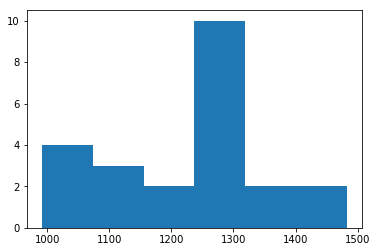

In [14]:
plt.hist( mouton_1982[ 'UnitPriceUSD'], 6 )
plt.show()

### Let's Try Your Own!

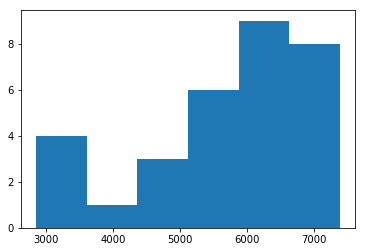

In [15]:
Vintage = "1999"
Producer = "Domaine de la Romanee Conti"
Wine = "La Tache"
producer_only = bottle_df[ bottle_df["ProducerAndDesignation"].str.contains(Producer) ]
producer_wine = producer_only[ producer_only["Wine"].str.contains(Wine) ]

producer_wine_vintage = producer_wine[ producer_wine['Vintage'] == Vintage ]

plt.hist( producer_wine_vintage['UnitPriceUSD'], 6 )
plt.show()

In [16]:
producer_wine_vintage.head()

,index,Auction.Date,Auction.ID,Auction.Name,BottleQuantity,BottleSummary,Conditions,Designation,LotNo,Producer,ProducerAndDesignation,Size,SoldAmount,Vintage,Wine,SoldAmountUSD,UnitPriceUSD,Date
580,3337,,1197.0,"185A Sep 22, 2018 (HK)",6.0,6 bottles,1x6 bottle banded owc,,317,Domaine de la Romanee Conti,Domaine de la Romanee Conti,bottle,297600.0,1999,La Tache,38003.520,6333.920000,2018-09-22
2219,7762,,1192.0,"185 Jun 20, 2018 (NY)",1.0,1 bottle,,,1069,Domaine de la Romanee Conti,Domaine de la Romanee Conti,bottle,5952.0,1999,La Tache,5952.000,5952.000000,2018-06-20
2462,8073,,1192.0,"185 Jun 20, 2018 (NY)",12.0,12 bottles,1x12 bottle owc 3 bottles different importer,,1372,Domaine de la Romanee Conti,Domaine de la Romanee Conti,bottle,74400.0,1999,La Tache,74400.000,6200.000000,2018-06-20
2727,8468,,1190.0,"184A Jun 9, 2018 (HK)",3.0,3 bottles,,,295,Domaine de la Romanee Conti,Domaine de la Romanee Conti,bottle,138880.0,1999,La Tache,17734.976,5911.658667,2018-06-09
2799,8575,,1190.0,"184A Jun 9, 2018 (HK)",3.0,3 bottles,1vlbsl,,377,Domaine de la Romanee Conti,Domaine de la Romanee Conti,bottle,158720.0,1999,La Tache,20268.544,6756.181333,2018-06-09


## PnL Opportunity

In [17]:
bottle_profit = bottle_grouped[ bottle_grouped["max"] / 1.25 > bottle_grouped["min"] ]
bottle_profit = bottle_profit.reset_index()
bottle_profit['diff'] = bottle_profit['max'] / 1.25 - bottle_profit['min']
bottle_profit = bottle_profit[ bottle_profit["count"] > 10 ]
bottle_profit = bottle_profit.sort_values('diff', ascending = False)
print(bottle_profit.shape)
bottle_profit.head()

(72, 11)


,index,Vintage,Wine,ProducerAndDesignation,Producer,Designation,min,mean,max,count,diff
4,2120,1999,Romanee Conti,Domaine de la Romanee Conti,Domaine de la Romanee Conti,,10028.706667,18481.627333,23224.373333,24,8550.792
2,2081,1999,La Tache,Domaine de la Romanee Conti,Domaine de la Romanee Conti,,2841.666667,5658.579462,7389.573333,31,3069.992
41,2007,1999,Chambertin,A. Rousseau,A. Rousseau,,899.000000,2914.087885,4960.000000,13,3069.000
42,1185,1990,Chambertin,A. Rousseau,A. Rousseau,,3224.000000,4757.275897,7750.000000,13,2976.000
62,2620,2002,Romanee Conti,Domaine de la Romanee Conti,Domaine de la Romanee Conti,,12616.760000,15934.525697,19001.760000,11,2584.648


# Price momentum over time
For each unique bottle type - [Vintage, Wine, ProducerAndDesignation], use the historical price time series to compute the Annual Percent Change. Fit a linear regression through the price points as a function of ordinal date, then normalize to get the annual percent change. Interpret the Annual Percent Change as the price drift over time.
Also plot the price time series

In [18]:
# Use these filters to scope the bottles
Vintage = ''
Producer = ''
Wine = 'Mouton'
count_threshold = 10

In [19]:
bottle_grouped_percent_change, high_count_bottles = enrich_bottle_price_percent_change(bottle_df, count_threshold = count_threshold)
#bottle_grouped_percent_change.head()
bottle_grouped_percent_change_in_scope = bottle_grouped_percent_change
bottle_grouped_percent_change_in_scope = bottle_grouped_percent_change_in_scope[ 
                                            bottle_grouped_percent_change_in_scope["ProducerAndDesignation"].str.contains(Producer) &
                                            bottle_grouped_percent_change_in_scope["Wine"].str.contains(Wine) &
                                            bottle_grouped_percent_change_in_scope["Vintage"].str.contains(Vintage)
                                            ]
high_count_bottles_in_scope = high_count_bottles
high_count_bottles_in_scope = high_count_bottles_in_scope[ 
                                            high_count_bottles_in_scope["ProducerAndDesignation"].str.contains(Producer) &
                                            high_count_bottles_in_scope["Wine"].str.contains(Wine) &
                                            high_count_bottles_in_scope["Vintage"].str.contains(Vintage)
                                            ]

In [20]:
bottle_grouped_percent_change_in_scope.head()

,Vintage,Wine,ProducerAndDesignation,Producer,Designation,min,mean,max,count,Annual Percent Change
3,2000,Chateau Mouton Rothschild,Chateau Mouton Rothschild,Chateau Mouton Rothschild,,1766.346400,1999.909783,2365.642500,25,0.144828
109,1995,Chateau Mouton Rothschild,Chateau Mouton Rothschild,Chateau Mouton Rothschild,,499.413417,535.796175,568.333333,10,0.083935
7,1986,Chateau Mouton Rothschild,Chateau Mouton Rothschild,Chateau Mouton Rothschild,,806.000000,905.878661,1033.333333,23,0.035559
5,1982,Chateau Mouton Rothschild,Chateau Mouton Rothschild,Chateau Mouton Rothschild,,992.000000,1215.591410,1482.000000,23,-0.117320


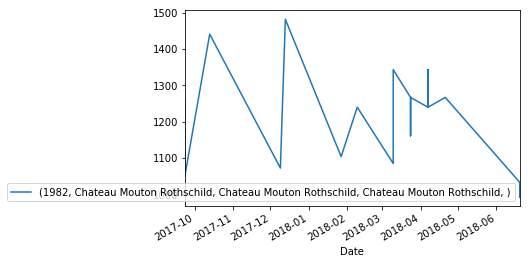

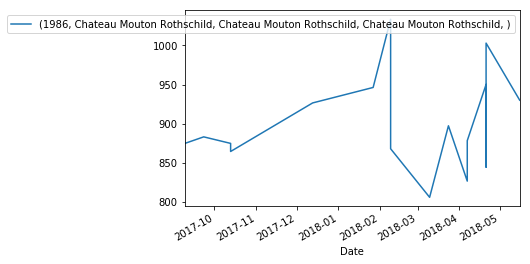

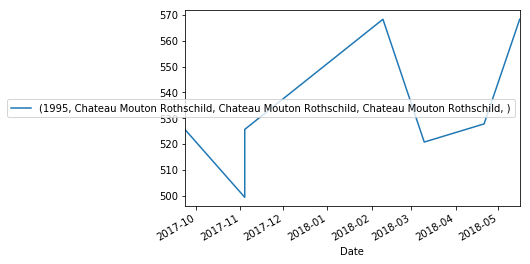

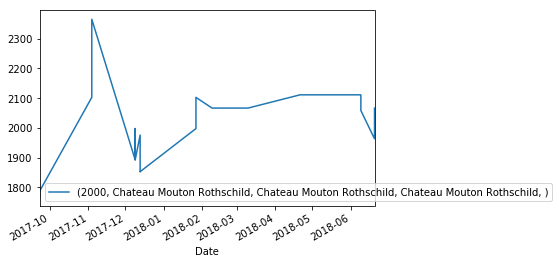

In [21]:
for unique_bottle_key, single_bottle_timeseries in high_count_bottles_in_scope.groupby(unique_bottle_keys):
    plot_price_over_time(single_bottle_timeseries)

# Read Current Auction From Spreadsheet + Scrape the Bid Data
Acker website has a xls sheet of auction items for each live + online auction. We enrich this dataset w/ scraped bid data

In [64]:
# Scrape the bid data
# Use this if you have the Raw Current Auction Data cached
auction_id = 1216
filename = 'Online Auction_1Jan19_2674 Lots Scraped Bid Data.csv'
try:
    current_auction_scraped_bids_raw_df = pd.read_csv(filename,na_filter=False) 
# Scrapes and writes to csv the raw data
except FileNotFoundError:    
    current_auction_scraped_bids_raw_df = ack_scraper.dataframe_current_auction(auction_id)
    current_auction_scraped_bids_raw_df.to_csv(filename, encoding='utf-8', index=False)

In [67]:
# Process the bid data and join against the Current Auction Spreadsheet
current_auction_price_cols_to_retain = ['currentBid','estimateHigh', 'estimateLow', 'lotNo', 'reservePrice', 'winningBidderPaddle', 'winningBidderUserName' ,
                                       'bottleQuantity', 'bottleSize', 'designation', 'isMixedLot', 'producerName', 'region', 
                                        'vintage', 'wineName', 'condition'
                                       ]
current_auction_scraped_bids_df = current_auction_scraped_bids_raw_df[current_auction_price_cols_to_retain]
scraped_bids_col_rename_map = {
    'lotNo' : 'LotNo',
    'bottleQuantity' : 'BottleQuantity', 
    'bottleSize' : 'Size',
    'designation' : 'Designation',
    'producerName' : 'Producer',
    'vintage' : 'Vintage',
    'wineName' : 'Wine'
}
current_auction_scraped_bids_df = current_auction_scraped_bids_df.rename( columns = scraped_bids_col_rename_map)
# If the wine is missing both producer & designation, set producer = wine name, really don't know if this actually fixes it.
# Check this ERICK!!!
current_auction_scraped_bids_df.loc[(current_auction_scraped_bids_df['Producer']=='') & (current_auction_scraped_bids_df['Designation'] =='') , 'Producer'] = current_auction_scraped_bids_df['Wine'] 

# Replace all currentBids = 0, w/ nulls
current_auction_scraped_bids_df['currentBid'] = current_auction_scraped_bids_df['currentBid'].replace(0, np.nan)
#joined_current_auction = pd.merge(raw_current_auction, current_auction_scraped_bids_df, on=['LotNo'])

In [68]:
current_auction_scraped_bids_df.head()

,currentBid,estimateHigh,estimateLow,LotNo,reservePrice,winningBidderPaddle,winningBidderUserName,BottleQuantity,Size,Designation,isMixedLot,Producer,region,Vintage,Wine,condition
0,190.0,280,200,1,180,8463,soulfish,1,bottle,,False,Chateau Pavie,Red Bordeaux,1998,Chateau Pavie,
1,320.0,500,350,2,300,48149,******,1,bottle,,False,Dujac,Red Burgundy,2003,Clos de la Roche,bsl
2,400.0,600,450,3,400,5995,whocares,1,magnum,Vieilles Vignes,False,Ponsot,Red Burgundy,2003,Clos St. Denis,
3,130.0,200,150,4,130,8937,a9230,1,magnum,,False,Domaine Leflaive,White Burgundy,2010,Puligny Montrachet,bsl nc
4,300.0,500,350,5,300,37494,lotus125,1,bottle,Rose,False,Dom Perignon,Champagne,1996,Dom Perignon Vintage Champagne,


In [69]:
# Filter the Current Auction Spreadsheet by Wine in Scope
print('Original DF Size: ', current_auction_scraped_bids_df.shape)
# Only keep single lot items
current_auction_df = current_auction_scraped_bids_df.drop_duplicates(subset=['LotNo'], keep=False)
print('Less multilot DF size:', current_auction_df.shape)

# Only keep Bottles
current_auction_df = current_auction_df[
                                (current_auction_df["Size"].str.contains("bottle") == True) & 
                                (current_auction_df["Size"].str.contains("half") == False)
                                ]
print('Less multilot and nonbottle DF size:', current_auction_df.shape)
current_auction_df = current_auction_df.reset_index(drop = True)

Original DF Size:  (3210, 16)
Less multilot DF size: (2373, 16)
Less multilot and nonbottle DF size: (2146, 16)


## Join the current auction against the historical auction data

In [70]:
# Join the current auction against the historical Summary Stats for Each wine + Vintage
unique_bottle_keys = ['Wine', 'Vintage', 'Producer', 'Designation']
current_auction_df_historical = pd.merge(current_auction_df, bottle_grouped, how = 'left', on=unique_bottle_keys)
# The spreadsheet data doesn't always have the correct Producer + Designation info. 
# We're going to have to scrape the accurate Producer + Designation column from the website
# We need to create our own ProducerAndDesignation column, which is "Designation, Producer"
# This sux

## Enrich w/ PNL Opportunity ($ and %), if traded at historical min, mean, max

In [71]:
current_auction_df_historical['PNL_$_min'] = current_auction_df_historical['min'] * current_auction_df_historical['BottleQuantity'] - current_auction_df_historical['currentBid']
current_auction_df_historical['PNL_$_mean'] = current_auction_df_historical['mean'] * current_auction_df_historical['BottleQuantity'] - current_auction_df_historical['currentBid']
current_auction_df_historical['PNL_$_max'] = current_auction_df_historical['max'] *current_auction_df_historical['BottleQuantity'] - current_auction_df_historical['currentBid']  
current_auction_df_historical['PNL_%_min'] = current_auction_df_historical['PNL_$_min'] / current_auction_df_historical['currentBid']
current_auction_df_historical['PNL_%_mean'] = current_auction_df_historical['PNL_$_mean'] / current_auction_df_historical['currentBid']
current_auction_df_historical['PNL_%_max'] = current_auction_df_historical['PNL_$_max'] / current_auction_df_historical['currentBid']

## Let's filter down the bottle universe for the current auction

In [72]:
# Take a defensive copy of the entire bottle universe
filtered_cols_in_scope = ['currentBid', 'estimateHigh', 'estimateLow', 'LotNo', 
       'winningBidderPaddle', 'BottleQuantity',
       'Designation', 'Producer', 'Vintage', 'Wine', 'condition', 'min', 'mean', 'max',
       'count', 'PNL_$_min', 'PNL_$_mean', 'PNL_%_min',
       'PNL_%_mean', ]
current_auction_df_historical_filtered = current_auction_df_historical[filtered_cols_in_scope]
current_auction_df_historical_filtered_defensive = current_auction_df_historical_filtered
print('Total Number of Starting Lots (Bottle, Single Lot):', current_auction_df_historical_filtered.shape[0])

# Current auction lots where we can find a historical match, joined on [Wine, vintage, Producer, Designation]
current_auction_df_historical_filtered = current_auction_df_historical_filtered.dropna(subset=['count'])
print('Number of Lots with historical prices:', current_auction_df_historical_filtered.shape[0])

# Filter out lots w/o bids
current_auction_df_historical_filtered = current_auction_df_historical_filtered[current_auction_df_historical_filtered['currentBid'] > 0]
print('Lots with Bids:', current_auction_df_historical_filtered.shape[0])

# Current auction lots w/ positive PNL if we can sell at historical mean price
current_auction_df_historical_filtered = current_auction_df_historical_filtered[current_auction_df_historical_filtered['PNL_$_mean'] > 0]
print('Number of Lots with Positive PNL at mean historical price:', current_auction_df_historical_filtered.shape[0])
print('PNL Estimate from executing all Positive PNL trades: $%i' % round(current_auction_df_historical_filtered['PNL_$_mean'].sum()))
print('Balance sheet req for executing all Positive PNL trades: $%i'% round(current_auction_df_historical_filtered['currentBid'].sum()))

current_auction_df_historical_filtered.sort_values(by=['PNL_%_mean'], ascending = False).head()

Total Number of Starting Lots (Bottle, Single Lot): 2146
Number of Lots with historical prices: 381
Lots with Bids: 173
Number of Lots with Positive PNL at mean historical price: 170
PNL Estimate from executing all Positive PNL trades: $49543
Balance sheet req for executing all Positive PNL trades: $100815


,currentBid,estimateHigh,estimateLow,LotNo,winningBidderPaddle,BottleQuantity,Designation,Producer,Vintage,Wine,condition,min,mean,max,count,PNL_$_min,PNL_$_mean,PNL_%_min,PNL_%_mean
829,260.0,400,300,1009,5804,1,Montee de Tonnerre,Raveneau,2010,Chablis,,395.200000,507.600000,620.000000,2.0,135.200000,247.600000,0.520000,0.952308
461,220.0,350,260,585,53426,1,,Chateau Mouton Rothschild,1981,Chateau Mouton Rothschild,bn nl stl,422.261333,422.261333,422.261333,1.0,202.261333,202.261333,0.919370,0.919370
484,2800.0,5000,3500,612,34283,10,Cristal,louis roederer,1990,Louis Roederer Vintage Champagne,1bsl 1lscl 3lbsl 4nl,535.166667,535.166667,535.166667,1.0,2551.666667,2551.666667,0.911310,0.911310
228,2800.0,5000,3500,304,5995,12,,Dom Perignon,1988,Dom Perignon Vintage Champagne,2nl,434.000000,434.000000,434.000000,1.0,2408.000000,2408.000000,0.860000,0.860000
479,40.0,80,60,605,17935,1,,Chateau Suduiraut,1990,Chateau Suduiraut,beautiful amber color lscl,73.597767,73.597767,73.597767,1.0,33.597767,33.597767,0.839944,0.839944


In [83]:
bottle_grouped[(bottle_grouped['Wine'].str.contains('Chateau Pavie')) & (bottle_grouped['Vintage'] == '1998')]

,Vintage,Wine,ProducerAndDesignation,Producer,Designation,min,mean,max,count
1919,1998,Chateau Pavie,Chateau Pavie,Chateau Pavie,,263.913333,266.721111,268.666667,3


In [81]:
current_auction_df_historical_filtered_defensive.head(20)

,currentBid,estimateHigh,estimateLow,LotNo,winningBidderPaddle,BottleQuantity,Designation,Producer,Vintage,Wine,condition,min,mean,max,count,PNL_$_min,PNL_$_mean,PNL_%_min,PNL_%_mean
0,190.0,280,200,1,8463,1,,Chateau Pavie,1998,Chateau Pavie,,263.913333,266.721111,268.666667,3.0,73.913333,76.721111,0.389018,0.403795
1,320.0,500,350,2,48149,1,,Dujac,2003,Clos de la Roche,bsl,473.128500,473.128500,473.128500,1.0,153.128500,153.128500,0.478527,0.478527
2,300.0,500,350,5,37494,1,Rose,Dom Perignon,1996,Dom Perignon Vintage Champagne,,360.250000,420.188379,516.666667,11.0,60.250000,120.188379,0.200833,0.400628
3,NaN,110,80,6,0,1,,Fontodi,2012,Flaccianello,,77.208333,85.020833,103.333333,4.0,NaN,NaN,NaN,NaN
4,180.0,260,200,7,48149,1,Herb Lamb Vineyard,Colgin,1993,Colgin Cabernet Sauvignon,bn ssos,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,200.0,320,240,8,48149,1,Herb Lamb Vineyard,Colgin,1994,Colgin Cabernet Sauvignon,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,140.0,200,150,9,8463,1,Herb Lamb Vineyard,Colgin,1998,Colgin Cabernet Sauvignon,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,160,120,10,0,1,Red Rock Terrace,Diamond Creek,1985,Diamond Creek Cabernet Sauvignon,bn lbsl sdc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,80.0,120,90,11,56120,1,Red Rock Terrace,Diamond Creek,1989,Diamond Creek Cabernet Sauvignon,bn lbsl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,95.0,150,110,12,16598,1,Howell Mountain,,1997,Dunn Vineyards Cabernet Sauvignon,crc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
current_auction_df_historical_filtered[current_auction_df_historical_filtered['Wine'].str.contains('Mouton')].head()

,currentBid,estimateHigh,estimateLow,LotNo,winningBidderPaddle,BottleQuantity,Designation,Producer,Vintage,Wine,condition,min,mean,max,count,PNL_$_min,PNL_$_mean,PNL_%_min,PNL_%_mean
69,700.0,1200,900,91,62412,1,,Chateau Mouton Rothschild,1982,Chateau Mouton Rothschild,lstl nl ts vlbsl,992.000000,1215.591410,1482.000000,23.0,292.000000,515.591410,0.417143,0.736559
87,1400.0,2200,1600,113,21447,1,,Chateau Mouton Rothschild,2000,Chateau Mouton Rothschild,,1766.346400,1999.909783,2365.642500,25.0,366.346400,599.909783,0.261676,0.428507
310,300.0,480,350,414,53426,1,,Chateau Mouton Rothschild,1988,Chateau Mouton Rothschild,bsl,413.333333,446.187467,504.670400,3.0,113.333333,146.187467,0.377778,0.487292
461,220.0,350,260,585,53426,1,,Chateau Mouton Rothschild,1981,Chateau Mouton Rothschild,bn nl stl,422.261333,422.261333,422.261333,1.0,202.261333,202.261333,0.919370,0.919370
463,350.0,600,450,587,53426,1,,Chateau Mouton Rothschild,1995,Chateau Mouton Rothschild,lscl ts,499.413417,535.796175,568.333333,10.0,149.413417,185.796175,0.426895,0.530846


In [79]:
#current_auction_df.head()

## Who are the active bidders? What are they buying?

In [80]:
current_auction_bidders = current_auction_scraped_bids_df.groupby(['winningBidderPaddle', 'winningBidderUserName']).agg({"LotNo": pd.Series.nunique})
current_auction_bidders = current_auction_bidders.reset_index()
current_auction_bidders = current_auction_bidders.rename(columns = {'LotNo':'User Bid Count'})
current_auction_bidders = current_auction_bidders.sort_values(by=['User Bid Count'], ascending = False)
current_auction_bidders.head()

,winningBidderPaddle,winningBidderUserName,User Bid Count
0,0,***,1687
80,16598,harper,42
170,53426,mh***,34
184,56120,thundermountainconsulting,21
167,52176,***,19


In [36]:
joined_current_auction_bidders = pd.merge(current_auction_scraped_bids_df, current_auction_bidders, on = ['winningBidderPaddle', 'winningBidderUserName'])
# get rid of lots w/ no winning bids
joined_current_auction_bidders = joined_current_auction_bidders[joined_current_auction_bidders['winningBidderPaddle'] != 0]
joined_current_auction_bidders = joined_current_auction_bidders.sort_values(by=['User Bid Count'], ascending = False)
joined_current_auction_bidders.head()

,currentBid,estimateHigh,estimateLow,LotNo,reservePrice,winningBidderPaddle,winningBidderUserName,BottleQuantity,Size,Designation,isMixedLot,Producer,region,Vintage,Wine,condition,User Bid Count
2091,220.0,320,240,2011,200,16598,harper,4,bottle,Napa Valley,False,silver oak,California Cabernets & Meritage,2009,Silver Oak Cabernet Sauvignon,,42
2099,120.0,200,150,2090,120,16598,harper,1,bottle,Ueberroth Vineyard,True,Turley,California Red,2002,Turley Zinfandel,,42
2073,120.0,180,130,832,100,16598,harper,1,bottle,SLV,True,,California Cabernets & Meritage,1998,Stag's Leap Wine Cellars Cabernet Sauvignon,nl,42
2072,120.0,180,130,832,100,16598,harper,1,bottle,Fay Vineyard,True,,California Cabernets & Meritage,1998,Stag's Leap Wine Cellars Cabernet Sauvignon,,42
2071,120.0,180,130,832,100,16598,harper,1,bottle,Alexander Valley,True,silver oak,California Cabernets & Meritage,2005,Silver Oak Cabernet Sauvignon,,42


## ToDos

In [37]:
#TODO list!
#check auction scraping - all web and in person
#can we scrape more dates? the archives go back longer
#PnL 
#Trend over time - signifcant outliers
#Expected inventory, distributions of profit? strategies? always buy < max?)
#Lot sizes makes difference?
#Ullage level?
#Label condition?
#mixed lots built from single bottles?